In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset


ANFIS-ANN

In [ ]:
# 📊 Step 2: Load and Prepare Dataset
data = pd.read_csv("diabetes.csv")
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    data[col] = data[col].replace(0, data[col].median())

features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = data[features].values
y = data['Outcome'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


# 🧠 Step 3: Define ANFIS Layer (Fuzzy First)
class GaussianMF(nn.Module):
    def __init__(self, in_features, n_mfs):
        super().__init__()
        self.mu = nn.Parameter(torch.rand(in_features, n_mfs))
        self.sigma = nn.Parameter(torch.rand(in_features, n_mfs))

    def forward(self, x):
        x = x.unsqueeze(2)  # [batch, features, 1]
        gauss = torch.exp(-((x - self.mu)**2) / (2 * self.sigma**2))
        return gauss.view(x.size(0), -1)  # flatten to [batch, features * mfs]


# 🔗 Step 4: Define Full ANFIS → ANN Model
class ANFISThenANN(nn.Module):
    def __init__(self, in_features, n_mfs, hidden_size):
        super().__init__()
        self.fuzzy = GaussianMF(in_features, n_mfs)
        self.ann = nn.Sequential(
            nn.Linear(in_features * n_mfs, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        fuzzy_output = self.fuzzy(x)
        return self.ann(fuzzy_output)

# ⚙️ Step 5: Train the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANFISThenANN(in_features=8, n_mfs=6, hidden_size=32).to(device)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.6)
train_losses = []
train_accuracies = []

# for epoch in range(150):
#     model.train()
#     total_loss = 0
#     for xb, yb in train_loader:
#         xb, yb = xb.to(device), yb.to(device)
#         preds = model(xb)
#         loss = criterion(preds, yb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     scheduler.step()
#     if (epoch + 1) % 10 == 0:
#         print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(train_loader):.4f}")

for epoch in range(150):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Accuracy on training data for this epoch
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_tensor.to(device)).cpu().numpy()
        train_preds_binary = (train_preds >= 0.5).astype(int)
        epoch_acc = accuracy_score(y_train, train_preds_binary)
        train_accuracies.append(epoch_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}, Accuracy = {epoch_acc*100:.2f}%")


# ✅ Step 6: Evaluate the Model
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).cpu().numpy()
    preds_binary = (preds >= 0.5).astype(int)
    acc = accuracy_score(y_test, preds_binary)

print(f"\n✅ Final Accuracy (ANFIS → ANN): {acc * 100:.2f}%")


cm_hybrid = confusion_matrix(y_test, preds_binary)
disp_hybrid = ConfusionMatrixDisplay(confusion_matrix=cm_hybrid,
                                     display_labels=['Non-Diabetic', 'Diabetic'])
disp_hybrid.plot(cmap=plt.cm.Purples)
plt.title("Hybrid ANFIS-ANN Confusion Matrix")
plt.savefig("hybrid_anfis_ann_confusion_matrix.png")
plt.close()


Epoch 10: Avg Loss = 0.4923, Accuracy = 77.20%
Epoch 20: Avg Loss = 0.4654, Accuracy = 77.85%
Epoch 30: Avg Loss = 0.4556, Accuracy = 79.48%
Epoch 40: Avg Loss = 0.4464, Accuracy = 79.32%
Epoch 50: Avg Loss = 0.4299, Accuracy = 79.48%
Epoch 60: Avg Loss = 0.4371, Accuracy = 80.46%
Epoch 70: Avg Loss = 0.4195, Accuracy = 80.62%
Epoch 80: Avg Loss = 0.4213, Accuracy = 79.80%
Epoch 90: Avg Loss = 0.4136, Accuracy = 80.29%
Epoch 100: Avg Loss = 0.4015, Accuracy = 80.62%
Epoch 110: Avg Loss = 0.4126, Accuracy = 80.62%
Epoch 120: Avg Loss = 0.4139, Accuracy = 80.46%
Epoch 130: Avg Loss = 0.4060, Accuracy = 80.94%
Epoch 140: Avg Loss = 0.4153, Accuracy = 80.78%
Epoch 150: Avg Loss = 0.4030, Accuracy = 80.94%

✅ Final Accuracy (ANFIS → ANN): 77.27%


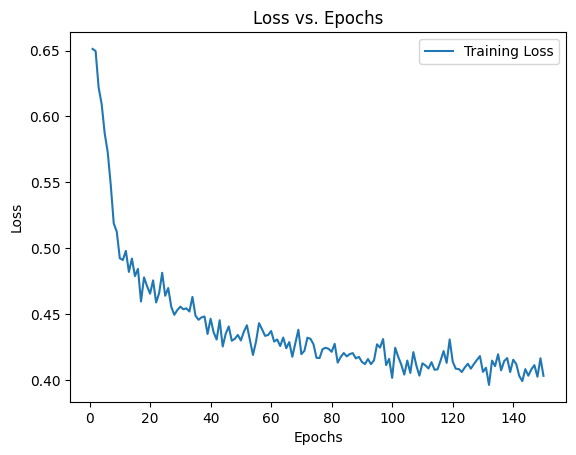

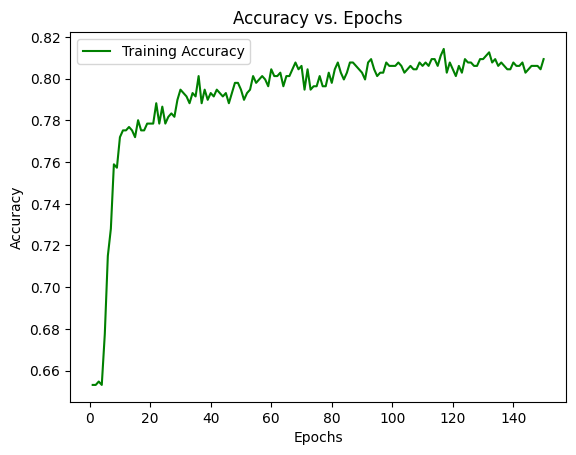

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses)+1)

plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()


FNN

In [ ]:
# ✅ Step 1: Install dependencies (Colab already has most preinstalled)
!pip install -q torch scikit-learn pandas numpy

# ✅ Step 2: Import required libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# ✅ Step 3: Load and preprocess the dataset
# Upload the diabetes.csv file manually in Colab, then run this:
data = pd.read_csv("diabetes.csv")

# Replace zero values in certain features with the median (prevents misleading input)
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zeros:
    data[col] = data[col].replace(0, data[col].median())

# Extract features and target
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = data[features].values
y = data['Outcome'].values

# Normalize feature values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


# ✅ Step 4: Prepare PyTorch tensors and dataloaders
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# ✅ Step 5: Define Feedforward ANN architecture
class FeedForwardANN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            # nn.Linear(input_size, 32),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(32, 16),
            # nn.ReLU(),
            # nn.Linear(16, 1),
            # nn.Sigmoid()
             nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedForwardANN(input_size=8).to(device)


# ✅ Step 6: Train the model
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)



X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)
train_losses = []
train_accuracies = []

# for epoch in range(100):
#     model.train()
#     epoch_loss = 0
#     for xb, yb in train_loader:
#         xb, yb = xb.to(device), yb.to(device)
#         optimizer.zero_grad()
#         preds = model(xb)
#         loss = criterion(preds, yb)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     if (epoch + 1) % 10 == 0:
#         print(f"Epoch {epoch+1}, Avg Loss = {epoch_loss / len(train_loader):.4f}")
for epoch in range(150):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Accuracy on training data for this epoch
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_tensor.to(device)).cpu().numpy()
        train_preds_binary = (train_preds >= 0.5).astype(int)
        epoch_acc = accuracy_score(y_train, train_preds_binary)
        train_accuracies.append(epoch_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}, Accuracy = {epoch_acc*100:.2f}%")


# ✅ Step 7: Evaluate model
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).cpu().numpy()
    preds_binary = (preds >= 0.5).astype(int)
    acc = accuracy_score(y_test, preds_binary)
    print(f"\n🎯 Final FNN Accuracy: {acc * 100:.2f}%")


cm_fnn = confusion_matrix(y_test, preds_binary)
disp_fnn = ConfusionMatrixDisplay(confusion_matrix=cm_fnn,
                                  display_labels=['Non-Diabetic', 'Diabetic'])
disp_fnn.plot(cmap=plt.cm.Blues)
plt.title("FNN Confusion Matrix")
plt.savefig("fnn_confusion_matrix.png")
plt.close()
print("FNN confusion matrix image saved successfully.")

Epoch 10: Avg Loss = 0.4380, Accuracy = 79.80%
Epoch 20: Avg Loss = 0.4256, Accuracy = 82.25%
Epoch 30: Avg Loss = 0.4827, Accuracy = 82.41%
Epoch 40: Avg Loss = 0.4186, Accuracy = 82.25%
Epoch 50: Avg Loss = 0.3975, Accuracy = 83.55%
Epoch 60: Avg Loss = 0.4206, Accuracy = 84.20%
Epoch 70: Avg Loss = 0.3646, Accuracy = 85.34%
Epoch 80: Avg Loss = 0.3951, Accuracy = 86.64%
Epoch 90: Avg Loss = 0.3818, Accuracy = 84.36%
Epoch 100: Avg Loss = 0.3916, Accuracy = 85.18%
Epoch 110: Avg Loss = 0.3812, Accuracy = 86.48%
Epoch 120: Avg Loss = 0.3661, Accuracy = 86.81%
Epoch 130: Avg Loss = 0.3796, Accuracy = 85.67%
Epoch 140: Avg Loss = 0.3798, Accuracy = 87.13%
Epoch 150: Avg Loss = 0.3990, Accuracy = 86.97%

🎯 Final FNN Accuracy: 76.62%
FNN confusion matrix image saved successfully.


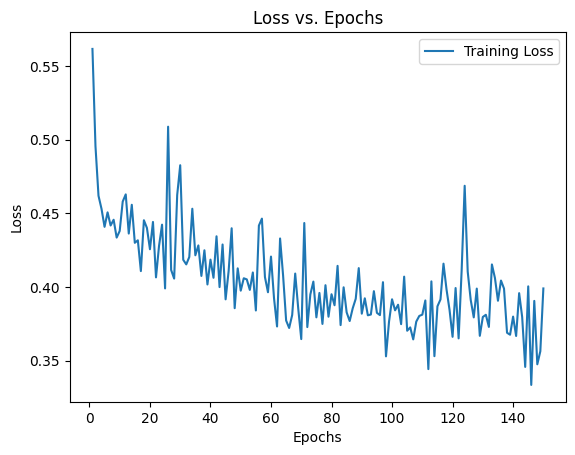

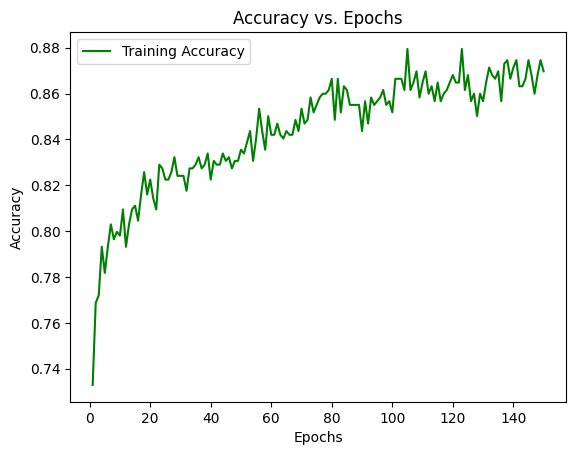

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses)+1)

plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()


anfis

In [ ]:
# ✅ Step 4: Prepare features and labels
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = data[features].values
y = data['Outcome'].values

# Normalize all features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# ✅ Step 5: Define fuzzy membership function (Gaussian)
class GaussianMF(nn.Module):
    def __init__(self, in_features, n_mfs):
        super().__init__()
        self.mu = nn.Parameter(torch.rand(in_features, n_mfs))     # Mean of each MF
        self.sigma = nn.Parameter(torch.rand(in_features, n_mfs))  # Width of each MF

    def forward(self, x):
        x = x.unsqueeze(2)  # shape: [batch, features, 1]
        return torch.exp(-((x - self.mu)**2) / (2 * self.sigma**2))  # Gaussian function


# ✅ Step 6: Define the full ANFIS model
class ANFIS(nn.Module):
    def __init__(self, in_features, n_mfs):
        super().__init__()
        self.mf = GaussianMF(in_features, n_mfs)
        self.linear = nn.Linear(in_features * n_mfs, 1)

    def forward(self, x):
        phi = self.mf(x)                    # shape: [batch, features, mfs]
        flat_phi = phi.view(x.size(0), -1)  # flatten to shape: [batch, features * mfs]
        return torch.sigmoid(self.linear(flat_phi))  # output probability


# ✅ Step 7: Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANFIS(in_features=8, n_mfs=5).to(device)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32).to(device)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
loss_fn = nn.BCELoss()
train_losses = []
train_accuracies = []
# Train for 100 epochs
# for epoch in range(150):
#     model.train()
#     output = model(X_train_tensor)
#     loss = loss_fn(output, y_train_tensor)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     scheduler.step()
#     if (epoch + 1) % 10 == 0:
#         print(f"Epoch {epoch+1}: Training Loss = {loss.item():.4f}")
for epoch in range(150):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Accuracy on training data for this epoch
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_tensor.to(device)).cpu().numpy()
        train_preds_binary = (train_preds >= 0.5).astype(int)
        epoch_acc = accuracy_score(y_train, train_preds_binary)
        train_accuracies.append(epoch_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}, Accuracy = {epoch_acc*100:.2f}%")


# ✅ Step 8: Evaluate accuracy
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy()
    predicted_classes = (predictions >= 0.5).astype(int)
    accuracy = accuracy_score(y_test, predicted_classes)

print(f"🎯 Final ANFIS Accuracy (real model, all features): {accuracy * 100:.2f}%")


cm_anfis = confusion_matrix(y_test, predicted_classes)
disp_anfis = ConfusionMatrixDisplay(confusion_matrix=cm_anfis,
                                    display_labels=['Non-Diabetic', 'Diabetic'])
disp_anfis.plot(cmap=plt.cm.Greens)
plt.title("Standard ANFIS Confusion Matrix")
plt.savefig("anfis_confusion_matrix.png")
plt.close()
print("Standard ANFIS confusion matrix image saved successfully.")

Epoch 10: Avg Loss = 0.4727, Accuracy = 79.15%
Epoch 20: Avg Loss = 0.4728, Accuracy = 77.20%
Epoch 30: Avg Loss = 0.4561, Accuracy = 77.52%
Epoch 40: Avg Loss = 0.4270, Accuracy = 80.13%
Epoch 50: Avg Loss = 0.4222, Accuracy = 79.48%
Epoch 60: Avg Loss = 0.4346, Accuracy = 78.99%
Epoch 70: Avg Loss = 0.4166, Accuracy = 79.80%
Epoch 80: Avg Loss = 0.4201, Accuracy = 80.94%
Epoch 90: Avg Loss = 0.4125, Accuracy = 80.62%
Epoch 100: Avg Loss = 0.4135, Accuracy = 80.78%
Epoch 110: Avg Loss = 0.4087, Accuracy = 80.62%
Epoch 120: Avg Loss = 0.4039, Accuracy = 80.94%
Epoch 130: Avg Loss = 0.4052, Accuracy = 80.78%
Epoch 140: Avg Loss = 0.4205, Accuracy = 80.78%
Epoch 150: Avg Loss = 0.4096, Accuracy = 80.78%
🎯 Final ANFIS Accuracy (real model, all features): 78.57%
Standard ANFIS confusion matrix image saved successfully.
